**We are team Brainstorming. We choose "WUXI BIO"	& "XINYI SOLAR" for pair trading. We also tune the PX_RATIO_THRESHOLD to 0.1 which is better than 0.05 and 0.15. Also, the defalut dollarvalue is 20000.**

# Import libraries and helper functions

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from datetime import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web

# Download the font to display Chinese
!wget https://github.com/kenwkliu/ideas/raw/master/colab/data/simhei.ttf
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
CNFont = FontProperties(fname='/content/simhei.ttf')

# Yahoo Finance
!pip install yfinance
import yfinance as yf

# Google colab interactive table
%load_ext google.colab.data_table 
%matplotlib inline

# 20220202: Temp workaround for the pandas upgrade
!pip install --upgrade openpyxl

### Helper functions
# Display the stock info in Chinese or not
def useChinese(use=True):
  # return STOCK_INFO_FILE, RESEARCH_AJD_CLOSE_FILE, TEST_AJD_CLOSE_FILE
  if use:
    return 'hkStocksQuotesChi.xlsx', 'researchHKStocksAdjClosePxChi.csv', 'testHKStocksAdjClosePxChi.csv'

  else:
    return 'hkStocksQuotes.xlsx', 'researchHKStocksAdjClosePx.csv', 'testHKStocksAdjClosePx.csv'


STOCK_INFO_FILE, RESEARCH_AJD_CLOSE_FILE, TEST_AJD_CLOSE_FILE = useChinese(False)

CHART_SIZE_X, CHART_SIZE_Y = 12, 8
SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y = 8, 6


# Plot stock pair chart
def plotPair(df, stockA, stockB, sizeX, sizeY):
  ax1 = df[stockA].plot(label=stockA, legend=True, figsize = (sizeX, sizeY))
  ax1.set_ylim(df[stockA].min(), df[stockA].max())

  ax2 = df[stockB].plot(secondary_y=True, label=stockB, legend=True, figsize = (sizeX, sizeY))
  ax2.set_ylim(df[stockB].min(), df[stockB].max())

  ax1.legend(prop=CNFont, loc=2)
  ax2.legend(prop=CNFont, loc=1)

  plt.show()


# Plot all many Pairs at the same time
def plotManyPair(pairsDf):
  for index, row in pairsDf.iterrows():
      print('\n', index, ':', row['stockA'], 'vs', row['stockB'], '(', row['corr'], ')')
      plotPair(stocks, row['stockA'], row['stockB'], SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y)


# Filter the correlated stock pairs with the THRESHOLD
def getCorrelatedPairs(stocksCorr, THRESHOLD=0.95):
  # filter the pairs with correlation values above the THRESHOLD
  highCorr = stocksCorr[((stocksCorr >= THRESHOLD) & (stocksCorr < 1))]
  highCorr = highCorr.unstack().sort_values(ascending=False).drop_duplicates()
  highCorr.dropna(inplace=True)
  highCorrDf = highCorr.to_frame().reset_index()
  highCorrDf.rename(columns = {'level_0':'stockA', 'level_1':'stockB', 0:'corr'}, inplace=True)

  # looks up the sectors for the stocksA and stockB
  cols = ['stockA', 'stockB', 'corr', 'sector_A', 'sector_B']
  pairsDf = highCorrDf.merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockA', right_on='shortName').merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockB', right_on='shortName', suffixes=('_A', '_B'))[cols]
  pairsDf['sameSector'] = (pairsDf['sector_A'] == pairsDf['sector_B'])
  
  return pairsDf


### back test related functions

# based on the reserch data to determind the trading params (Enter/Exit Points)
def researchTradingParams(researchData, stockA, stockB, threshold=0.05, dollarValue=20000):
  cols = [stockA, stockB]
  research_df = researchData[cols].copy()
  research_df.dropna(inplace = True)

  tradingParams = {}
  tradingParams['dollarValue'] = dollarValue

  # Calculate avgPxRatio for Exit (convergence)
  research_df['ratio'] = research_df[stockA] / research_df[stockB]
  avgPxRatio = research_df['ratio'].mean()
  tradingParams['avgPxRatio'] = avgPxRatio

  # Calculate shortA_longB_ratio for Entry (Divergence)
  shortA_longB_ratio = avgPxRatio * (1 + threshold)
  tradingParams['shortA_longB_ratio'] = shortA_longB_ratio

  # Calculate longA_shortB_ratio from Entry (Divergence)
  longA_shortB_ratio = avgPxRatio * (1 - threshold)
  tradingParams['longA_shortB_ratio'] = longA_shortB_ratio

  return tradingParams


# Determind the signal and dollarValue in the test data
# signal == -1: Long stockA Short stockB
# signal == 1: Short stockA Long stockB
# signal == 0: flat position
def backTest(testData, tradingParams, stockA, stockB):
  cols = [stockA, stockB]
  backTest_df = testData[cols].copy()
  backTest_df.dropna(inplace = True)

  # Get the tradingParams
  dollarValue = tradingParams['dollarValue']
  avgPxRatio = tradingParams['avgPxRatio']
  shortA_longB_ratio = tradingParams['shortA_longB_ratio']
  longA_shortB_ratio = tradingParams['longA_shortB_ratio']

  # Calculate the Price ratio in backTest_df
  backTest_df['pxRatio'] = backTest_df[stockA] / backTest_df[stockB]
  backTest_df['dollarValue'] = dollarValue
  
  # initialize the signal to 0
  backTest_df['signal'] = 0
  signal = 0

  # Determine the signal in each row of the backTest_df
  for index, row in backTest_df.iterrows():
    pxRatio = row['pxRatio']

    # mark signal = 1 if pxRatio > shortA_longB_ratio (Diverge outside the upper band)
    if pxRatio > shortA_longB_ratio:
      signal = 1

    # mark signal = -1 if pxRatio < longA_shortB_ratio (Diverge outside the lower band)
    elif pxRatio < longA_shortB_ratio:
      signal = -1

    else:
      # continue to mark signal = 1 if previous signal == 1 and pxRatio > avgPxRatio (Trade entered but not converge back yet)
      if signal == 1 and pxRatio > avgPxRatio:
        signal = 1

      # continue to mark signal = -1 if previous signal == -1 and pxRatio < avgPxRatio (Trade entered but not converge back yet)
      elif signal == -1 and pxRatio < avgPxRatio:
        signal = -1

      else:
        signal = 0

    backTest_df.loc[index, 'signal'] = signal

  return backTest_df


# determine pSignal and nSignal for up/down markers in plot
# pSignal and nSignal is for displaying the up/down markers in plotting chart only, they're not required for backtest calculation
def addSignalMarker(backTest_df):
  backTest_df['pSignal'] = np.where(backTest_df['signal'] == 1, backTest_df['pxRatio'], np.nan)
  backTest_df['nSignal'] = np.where(backTest_df['signal'] == -1, backTest_df['pxRatio'], np.nan)

  return backTest_df


# Combine the research and backtest for a Portfolio of Pairs
def researchAndBackTestPortfolio(pairsDf, researchData, testData, printOutput=True):
  pairsPortfolioBackTest = []

  for index, row in pairsDf.iterrows():
    stockA, stockB = row['stockA'], row['stockB']
    if printOutput: print(stockA, 'vs', stockB)
    tradingParams = researchTradingParams(researchData, stockA, stockB)
    pairsPortfolioBackTest.append(backTest(testData, tradingParams, stockA, stockB)[[stockA, stockB, 'signal', 'dollarValue']])

  return pairsPortfolioBackTest


# Download and import pairslib for calculating PnL
!wget https://github.com/kenwkliu/ideas/raw/master/colab/pairslib.py
import pairslib

--2022-02-04 15:54:05--  https://github.com/kenwkliu/ideas/raw/master/colab/data/simhei.ttf
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/simhei.ttf [following]
--2022-02-04 15:54:05--  https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/simhei.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9751960 (9.3M) [application/octet-stream]
Saving to: ‘simhei.ttf.1’

simhei.ttf.1        100%[===================>]   9.30M  --.-KB/s    in 0.1s    

2022-02-04 15:54:06 (83.5 MB/s) - ‘simhei.ttf.1’ saved [9751960/9751960]

The google.colab.data_table ext

# 1. Source the stocks data


In [ ]:
# Source the Chinese name and stock sectors from http://www1.hket.com/finance/chart/industry-index.do

# Get stock info from Yahoo Finance
stock = yf.Ticker("0700.HK")
stock.info

{'52WeekChange': -0.35716236,
 'SandP52WeekChange': 0.15195155,
 'address1': 'Tencent Binhai Towers',
 'address2': 'No. 33 Haitian 2nd Road Nanshan District',
 'algorithm': None,
 'annualHoldingsTurnover': None,
 'annualReportExpenseRatio': None,
 'ask': 479.2,
 'askSize': 0,
 'averageDailyVolume10Day': 19545671,
 'averageVolume': 19745391,
 'averageVolume10days': 19545671,
 'beta': 0.493304,
 'beta3Year': None,
 'bid': 479,
 'bidSize': 0,
 'bookValue': 89.821,
 'category': None,
 'circulatingSupply': None,
 'city': 'Shenzhen',
 'companyOfficers': [],
 'country': 'China',
 'currency': 'HKD',
 'currentPrice': 479,
 'currentRatio': 1.281,
 'dateShortInterest': None,
 'dayHigh': 483,
 'dayLow': 471,
 'debtToEquity': 35.624,
 'dividendRate': 1.6,
 'dividendYield': 0.0034,
 'earningsGrowth': 0.028,
 'earningsQuarterlyGrowth': 0.025,
 'ebitda': 182760996864,
 'ebitdaMargins': 0.33254,
 'enterpriseToEbitda': 25.46,
 'enterpriseToRevenue': 8.466,
 'enterpriseValue': 4653014056960,
 'exDividend

In [ ]:
# Get the pre-downloaded (2020-Jul) all HK stocks information from yahoo and merged with stock sectors
# Pandas support reading Excel directly
stocksInfo = pd.read_excel('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/' + STOCK_INFO_FILE)
stocksInfo

code        shortName  ...  forwardPE dividendDate
0      4333.HK          CISCO-T  ...        NaN          NaN
1      4335.HK          INTEL-T  ...        NaN          NaN
2      4338.HK      MICROSOFT-T  ...        NaN          NaN
3      9988.HK          BABA-SW  ...        NaN          NaN
4      0700.HK          TENCENT  ...  50.091408          NaN
...        ...              ...  ...        ...          ...
2730  83186.HK  CICCKRANECNET-R  ...        NaN          NaN
2731  83188.HK     CAM CSI300-R  ...        NaN          NaN
2732  83197.HK  CAM MSCI AINC-R  ...        NaN          NaN
2733  83199.HK  CSOP CTPBBOND-R  ...        NaN          NaN
2734  87001.HK    HUI XIAN REIT  ...   8.636364          NaN

[2735 rows x 70 columns]

In [ ]:
# list the unique industries names
industryNames = stocksInfo['industry'].unique()
print('Count:', len(industryNames))
print(industryNames)

Count: 23
['Information Technology' 'Financial' 'Telecommunications' 'Energy'
 'Food and Beverage' 'Real Estate Construction' 'Meida and Communications'
 'Medicine' 'Betting' 'Transportation, logistics and infrastructure'
 'Consumer Goods Manufacturing' 'Conglomerate' 'Retail' 'Electricity'
 'Automobile production and distribution' 'Industry'
 'Environmental protection' 'Consumer Service' 'Industrial Products'
 'Raw Materials' 'Index leveraged products' 'Fund' 'ETF']


In [ ]:
# list the unique sector names
sectorNames = stocksInfo['sector'].unique()
print('Count:', len(sectorNames))
print(sectorNames)

Count: 123
['Telecommunications Equipment' 'Semi-conductor' 'Technology and Software'
 'E-commerce and Internet' 'Online and Mobile Games'
 'State-owned China banks' 'China Telecom' 'International Insurance'
 'Bank' 'China Insurance' 'Other financial services' 'Oil and gas'
 'Alcoholic Beverages' 'Real Estate Development'
 'Media Entertainment Culture Publishing' 'Pharmaceutical'
 'China Properties' 'Macau Gaming' 'Public Transport' 'Toys'
 'Conglomerate' 'Biotechnology' 'Sporting Goods'
 'Gas and Public Utilities' 'Catering' 'Electric utility' 'Supermarket'
 'small and medium China banks' 'Automobile' 'Mobile phone related'
 'Machinery' 'Dairy related' 'Textile and Clothing' 'Healthcare'
 'Property Management and Agent' 'Auto sales' 'Infrastructure'
 'Agricultural and Fishery products'
 'Food and beverage Production and Wholesale' 'Local Telecom'
 'Real Estate Investment' 'Water utilities' 'Jewelry Watches' 'Snack Food'
 'Cement' 'Clothing Accessories' 'Photovoltaic Solar' 'Packaged f

# 2. **Stock Selection**: 
Choose the set of the stocks that wer are interested to trade in our portfolios

In [ ]:
# Exploring the data 
# Look at the subset of useful columns and sort by largest marketCap
SELECTED_COLUMNS = ['code', 'quoteType', 'shortName', 'industry', 'sector', 'marketCap', 'regularMarketPreviousClose', 'averageDailyVolume10Day']

stocksInfo[SELECTED_COLUMNS].sort_values(by=['marketCap'], ascending=False)

code quoteType  ... regularMarketPreviousClose averageDailyVolume10Day
2      4338.HK    EQUITY  ...                     500.00                     0.0
3      9988.HK    EQUITY  ...                     244.80              25690873.0
4      0700.HK    EQUITY  ...                     535.00              20457768.0
14     1398.HK    EQUITY  ...                       4.65             161543498.0
11     2318.HK    EQUITY  ...                      82.65              31290439.0
...        ...       ...  ...                        ...                     ...
2729  83170.HK    EQUITY  ...                      88.02                     NaN
2730  83186.HK    EQUITY  ...                      79.14                     NaN
2731  83188.HK    EQUITY  ...                      47.30                661361.0
2732  83197.HK    EQUITY  ...                      11.32                 10550.0
2733  83199.HK    EQUITY  ...                     102.90                   892.0

[2735 rows x 8 columns]

In [ ]:
# Before we look at the stock price correlation, select only liquid equity names for the trading purpose
# thus add a new colume 'turnover' 
stocksInfo['turnover'] = round(stocksInfo['regularMarketPreviousClose'] * stocksInfo['averageDailyVolume10Day'])

# Select only EQUITY and turnover is bigger than certain numbers
QUOTE_TYPE = 'EQUITY'
MIN_TURNOVER = 100000000  # 100 millions
SELECTED_COLUMNS = ['code', 'shortName', 'industry', 'sector', 'turnover']

stocksFilteredInfo = stocksInfo[(stocksInfo.quoteType == QUOTE_TYPE) & (stocksInfo.turnover > MIN_TURNOVER) & (stocksInfo.industry != 'ETF')].reset_index()
stocksFilteredInfo.sort_values(by=['turnover'], ascending=False)[SELECTED_COLUMNS]

code     shortName  ...                      sector      turnover
1    0700.HK       TENCENT  ...     Online and Mobile Games  1.094491e+10
0    9988.HK       BABA-SW  ...     E-commerce and Internet  6.289126e+09
27   0981.HK          SMIC  ...              Semi-conductor  5.881712e+09
3    3690.HK     MEITUAN-W  ...     E-commerce and Internet  4.727324e+09
8    0388.HK          HKEX  ...    Other financial services  2.732908e+09
..       ...           ...  ...                         ...           ...
140  0136.HK   HENGTEN NET  ...          Photovoltaic Solar  1.084515e+08
91   0880.HK  SJM HOLDINGS  ...                Macau Gaming  1.077015e+08
158  3606.HK   FUYAO GLASS  ...  Cars parts and maintenance  1.056159e+08
152  3933.HK    UNITED LAB  ...              Pharmaceutical  1.038379e+08
120  1268.HK  MEIDONG AUTO  ...                  Auto sales  1.035112e+08

[173 rows x 5 columns]

In [ ]:
# Industry Distribution (diversity) with an interactive pie chart
import plotly.express as px

# Count the company names per industry
industryCount = stocksFilteredInfo[['industry', 'code']].groupby(['industry']).count().reset_index()
industryCount.rename(columns={'code' : 'count'}, inplace=True)

# Concat the company names per industry
industryStocks = stocksFilteredInfo[['industry', 'shortName']].groupby(['industry'])['shortName'].apply(', '.join).reset_index()

# Sum the marketCap and turnover per industry
industryDetails = stocksFilteredInfo[['industry', 'marketCap', 'turnover']].groupby(['industry']).sum().reset_index()

# Combine all in one dataframe
industryInfo = industryCount.merge(industryStocks, on='industry', how='left')
industryInfo = industryInfo.merge(industryDetails, on='industry', how='left')

fig = px.pie(industryInfo, values='count', names='industry', hover_name='shortName', title='Industry Distribution')
fig.show()

In [ ]:
# Industry Distribution table
industryInfo.sort_values(by=['count'], ascending=False)

industry  ...      turnover
8                                      Financial  ...  1.751066e+10
18                      Real Estate Construction  ...  6.341136e+09
15                                      Medicine  ...  1.014198e+10
14                        Information Technology  ...  3.449564e+10
6                                         Energy  ...  3.686595e+09
0         Automobile production and distribution  ...  4.129304e+09
9                              Food and Beverage  ...  2.078364e+09
20                            Telecommunications  ...  4.606182e+09
17                                 Raw Materials  ...  1.482049e+09
3                   Consumer Goods Manufacturing  ...  1.445468e+09
19                                        Retail  ...  1.571438e+09
13                                      Industry  ...  1.186823e+09
1                                        Betting  ...  1.096199e+09
16                      Meida and Communications  ...  1.392047e+09
21  Transportation, logistics and infrastructure  ...  5.723589e+08
4                               Consumer Service  ...  5.678305e+08
12                           Industrial Products  ...  3.593988e+08
7                       Environmental protection  ...  2.591940e+08
2                                   Conglomerate  ...  4.301855e+08
11                      Index leveraged products  ...  1.207266e+09
10                                          Fund  ...  3.872289e+08
5                                    Electricity  ...  1.907916e+08

[22 rows x 5 columns]

In [ ]:
# download the daily stock price info (Open, High, Low, Close, Volume) from Yahoo
startDate = '2020-1-1'
allStockCodes = stocksFilteredInfo['code'].to_string(index=False).replace("\n", " ")

# auto_adjust=True: The closing price is adjusted
# Tencent 5 for 1 split: https://www.stocksplithistory.com/?symbol=TCEHY
data = yf.download(allStockCodes, start=startDate, group_by='ticker', auto_adjust=True)

columnNames = []
stocksDownload = []

for code, name in zip(stocksFilteredInfo['code'], stocksFilteredInfo['shortName']):
    if code in data:
      stocksDownload.append(data[code])
      columnNames.append(name)

[*********************100%***********************]  173 of 173 completed


In [ ]:
# look at the downloaded stock price
company = "TENCENT"
#company = "騰訊控股" 

index = columnNames.index(company)
#print(columnNames[index])
stocksDownload[index]

Open        High         Low       Close      Volume
Date                                                                  
2020-01-02  373.733827  382.684345  373.534945  380.297546  13991006.0
2020-01-03  385.866766  387.855770  379.104165  380.894257  15313106.0
2020-01-06  377.910723  377.910723  373.336008  375.325012  12123194.0
2020-01-07  378.706322  385.667836  377.910733  383.479950  17686346.0
2020-01-08  380.297544  383.678845  377.115156  379.899750  15529153.0
...                ...         ...         ...         ...         ...
2022-01-26  470.000000  476.600006  466.000000  473.600006  21619270.0
2022-01-27  465.000000  467.000000  457.799988  463.000000  20507145.0
2022-01-28  463.000000  464.000000  455.600006  460.000000  15027473.0
2022-01-31  471.200012  471.200012  471.200012  471.200012         0.0
2022-02-04  483.000000  483.000000  471.000000  479.000000  15930509.0

[518 rows x 5 columns]

In [ ]:
# Combine the stocks adjusted closes to one pandas data frame 
closes = [stock['Close'] for stock in stocksDownload]
stockCloses = pd.concat(closes, axis=1)
stockCloses.columns = columnNames

# To prevent lookahead bias, split the data into research period and test period
# The Pairs identification and the trading parameters (Entry / Exit) calculations will be based on research period
# Data in test period to for backtesting
researchData = stockCloses.loc['2020-01-01':'2020-12-31']
testData = stockCloses.loc['2021-01-01':]

# Export the data to csv file for downloading
#researchData.to_csv(RESEARCH_AJD_CLOSE_FILE, encoding='utf_8_sig')
#testData.to_csv(TEST_AJD_CLOSE_FILE, encoding='utf_8_sig')

researchData

BABA-SW     TENCENT  ...  FL2 CSOP HSI  LINK REIT
Date                                ...                         
2020-01-02  210.000000  380.297546  ...        10.400  75.700165
2020-01-03  212.000000  380.894257  ...        10.320  75.194260
2020-01-06  211.000000  375.325012  ...        10.160  74.642380
2020-01-07  212.600006  383.479950  ...        10.180  74.504417
2020-01-08  210.800003  379.899750  ...        10.040  74.228470
...                ...         ...  ...           ...        ...
2020-12-24  228.600006  555.984253  ...         8.760  66.077522
2020-12-28  210.000000  517.588928  ...         8.715  67.132454
2020-12-29  222.000000  529.057678  ...         8.865  67.995598
2020-12-30  236.199997  557.978821  ...         9.260  68.858727
2020-12-31  232.199997  564.461182  ...         9.315  67.947632

[249 rows x 173 columns]

In [ ]:
# In case the Yahoo stock download failed, read from the prepared csv file

#researchData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/' + RESEARCH_AJD_CLOSE_FILE, index_col=0)
#testData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/' + TEST_AJD_CLOSE_FILE, index_col=0)

#columnNames = list(researchData.columns)
#researchData


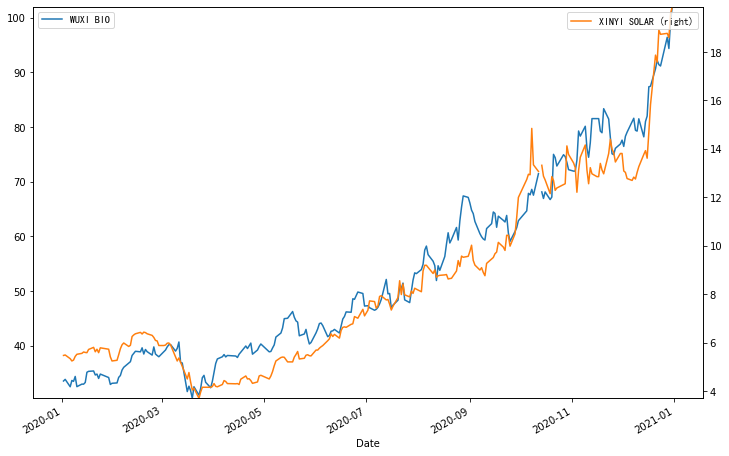

In [ ]:
# Pick 2 stocks price chart to to show the price correlation in research period
stockA = 'WUXI BIO'
stockB = 'XINYI SOLAR'
plotPair(researchData, stockA, stockB, CHART_SIZE_X, CHART_SIZE_Y)

In [ ]:
# Run the price correlation for all stock Pair combinations in research period
stocksCorr = researchData.corr()
stocksCorr.style.background_gradient(cmap='coolwarm', axis=None)

In [ ]:
# filter the pairs with correlation values above the THRESHOLD
THRESHOLD = 0.95
pairsDf = getCorrelatedPairs(stocksCorr, THRESHOLD)

pairsDf.round(4)

stockA  ... sameSector
0       XINYI SOLAR  ...      False
1         MEITUAN-W  ...      False
2     MAN WAH HLDGS  ...      False
3   ZHONGSHENG HLDG  ...      False
4       XINYI SOLAR  ...      False
..              ...  ...        ...
59  EVERSUNSHINE LS  ...       True
60  GREATWALL MOTOR  ...      False
61      WUXI APPTEC  ...      False
62       GEELY AUTO  ...      False
63     CHINA YOUZAN  ...      False

[64 rows x 6 columns]

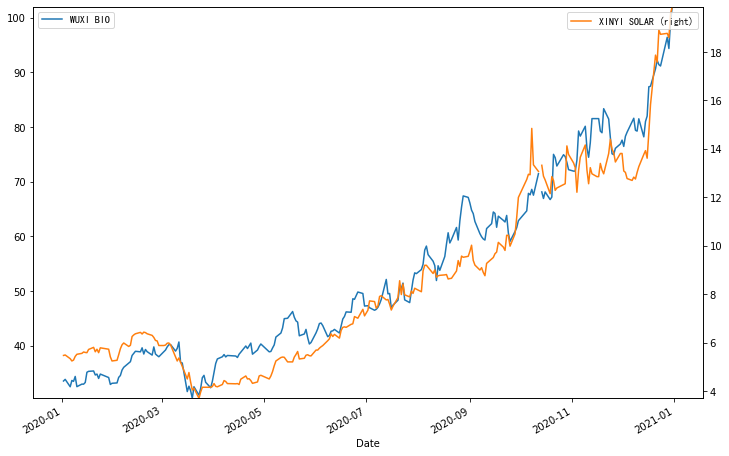

In [ ]:
# Pick a stock pair price chart to to show the price correlation
selected_pair = 10

PAIR_STOCK_A = pairsDf.loc[selected_pair]['stockA']
PAIR_STOCK_B = pairsDf.loc[selected_pair]['stockB']
plotPair(researchData, PAIR_STOCK_A, PAIR_STOCK_B, CHART_SIZE_X, CHART_SIZE_Y)

# Plot all the correlated Pairs with same sector
#plotManyPair(pairsDf[(pairsDf.sameSector == True)])

#4. Trading Parameters (Entry/Exit Point)

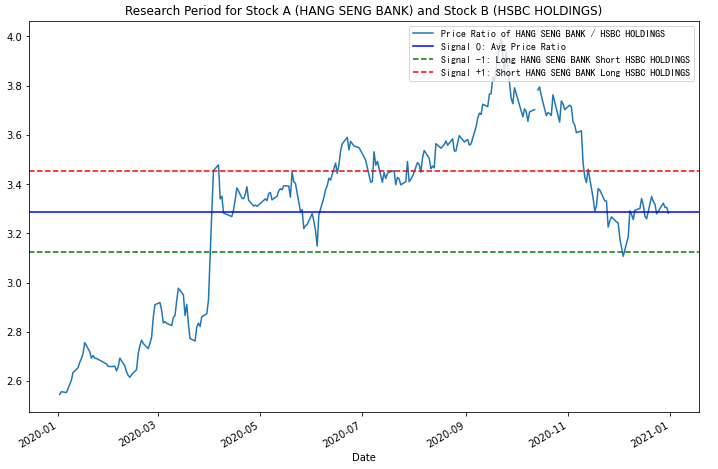

* **Price Ratio of Stock A/B**: the price relationship of stock A and B (Stock A price/ Stock B price) and it captures the **relative value**
* **Average Price Ratio of Stock A/B**: the average price ratio of the stock pair over the **research period** which represents **their long-term relationship**

* **Threshold**: define the **Divergence boundary** for trade **entry** points 

* **Entry Point** (Divergence)

 * **Signal -1: Long *under-value* Stock A and Short *over-value* Stock B** when the price ratio **drops below the divergence threshold** than the average price ratio. It happens when stock A drops relatively more than stock B or stock A rises relatively less than stock B. Hence stock A is now relatively under-value to stock B

 * **Signal +1: Short *over-value* Stock A and Long *under-value* Stock B** when price ratio **rises above the divergence theshold** than the average price ratio. It happens when stock A drops relatively less than stock B or stock A rises relatively more than stock B. Hence stock A is now relatively over-value to stock B

* **Exit Point** (Convergence)

 * **Signal 0: Rewind the Position** if already created the above long/short positions, **reverse the above trade to close out the positions** when the stock pair price ratio **reverse back to the average price ratio**


In [ ]:
# Running the price ratio which represent the relative price value
# Calculate the stock price ratios of (Stock A / Stock B) over the research period
pairResearchData = researchData[[PAIR_STOCK_A, PAIR_STOCK_B]].copy()

AB_stock = PAIR_STOCK_A + " / " + PAIR_STOCK_B
pairResearchData[AB_stock] = pairResearchData[PAIR_STOCK_A] / pairResearchData[PAIR_STOCK_B]

pairResearchData[[PAIR_STOCK_A, PAIR_STOCK_B, AB_stock]]

WUXI BIO  XINYI SOLAR  WUXI BIO / XINYI SOLAR
Date                                                       
2020-01-02   33.566666     5.467595                6.139201
2020-01-03   33.866665     5.486647                6.172561
2020-01-06   32.516666     5.334239                6.095839
2020-01-07   33.666664     5.238986                6.426180
2020-01-08   33.500000     5.277087                6.348199
...                ...          ...                     ...
2020-12-24   91.150002    18.733870                4.865519
2020-12-28   96.400002    18.772938                5.135051
2020-12-29   94.349998    18.597126                5.073364
2020-12-30   99.349998    19.583632                5.073114
2020-12-31  102.000000    19.876654                5.131649

[249 rows x 3 columns]

Average BUY/SELL price ratio of WUXI BIO / XINYI SOLAR in research period: 6.633393487601221
Entry Point (Divergence) Signal -1 (Long A Short B): Long WUXI BIO and Short XINYI SOLAR when the BUY/SELL price ratio < 5.970054138841099
Entry Point (Divergence) Signal +1 (Short A Long B): Short WUXI BIO and Long XINYI SOLAR when the BUY/SELL price ratio > 7.296732836361343
Exit Poiont (Convergence) Signal 0: Unwind the open Long/Short positions at average price ratio:  6.633393487601221


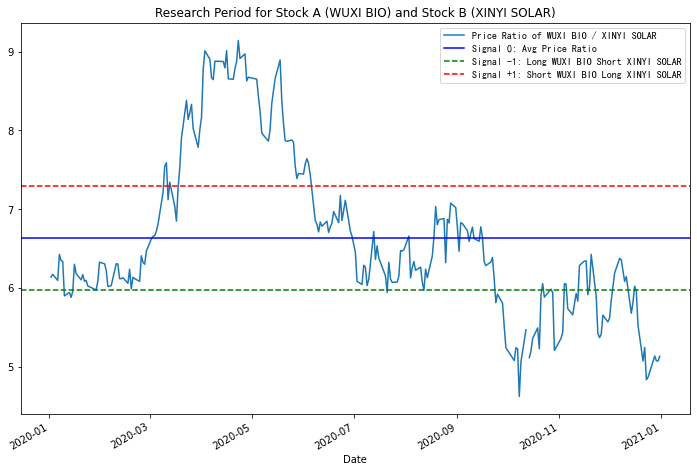

In [ ]:
# Calculate the trading parameters from research period
PX_RATIO_THRESHOLD = 0.1
tradingParams = researchTradingParams(pairResearchData, PAIR_STOCK_A, PAIR_STOCK_B, PX_RATIO_THRESHOLD)

avgPxRatio = tradingParams['avgPxRatio']
longA_shortB_ratio = tradingParams['longA_shortB_ratio']
shortA_longB_ratio = tradingParams['shortA_longB_ratio']

print("Average BUY/SELL price ratio of", AB_stock, "in research period:", avgPxRatio)

# Plot the averge price ratio in research period
labelTitle = 'Research Period for Stock A ({}) and Stock B ({})'.format(PAIR_STOCK_A, PAIR_STOCK_B)
labelPriceRatio = 'Price Ratio of {} / {}'.format(PAIR_STOCK_A, PAIR_STOCK_B)
pairResearchData[AB_stock].plot(title=labelTitle, label=labelPriceRatio, legend=True, figsize=(CHART_SIZE_X, CHART_SIZE_Y))

labelAvgPrice = 'Signal 0: Avg Price Ratio ' 
plt.axhline(y=avgPxRatio, label=labelAvgPrice, color='b', linestyle='-')
plt.legend(loc ='upper right')

labelLongAShortB = 'Signal -1: Long ' + PAIR_STOCK_A + ' Short ' + PAIR_STOCK_B
plt.axhline(y=longA_shortB_ratio, label=labelLongAShortB, color='g', linestyle='--')

labelShortALongB = 'Signal +1: Short ' + PAIR_STOCK_A + ' Long ' + PAIR_STOCK_B
plt.axhline(y=shortA_longB_ratio, label=labelShortALongB, color='r', linestyle='--')

plt.legend(loc ='upper right', prop=CNFont)

print("Entry Point (Divergence) Signal -1 (Long A Short B): Long", PAIR_STOCK_A, "and Short", PAIR_STOCK_B, "when the BUY/SELL price ratio <", longA_shortB_ratio)
print("Entry Point (Divergence) Signal +1 (Short A Long B): Short", PAIR_STOCK_A, "and Long", PAIR_STOCK_B, "when the BUY/SELL price ratio >", shortA_longB_ratio)
print("Exit Poiont (Convergence) Signal 0: Unwind the open Long/Short positions at average price ratio: ", avgPxRatio)

#5. Backtesting

Entry Point (Divergence) Signal == -1 (Long A Short B): Long WUXI BIO and Short XINYI SOLAR when the BUY/SELL price ratio < 5.970054138841099
Entry Point (Divergence) Signal == 1 (Short A Long B): Short WUXI BIO and Long XINYI SOLAR when the BUY/SELL price ratio > 7.296732836361343
Exit Poiont (Convergence) Signal == 0 : Within the above range or Unwind the open Long/Short positions at average price ratio:  6.633393487601221
------------------------------------------------------------------------------------------------------------
Use the default $20,000 when entering the trade (i.e. create $20,000 long and $20,000 short exposure at the same time)
Assume no transaction cost, perfect execution (can long/short at equal dollar amount), no short borrowing cost)
*** PnL: 16618.05523151922


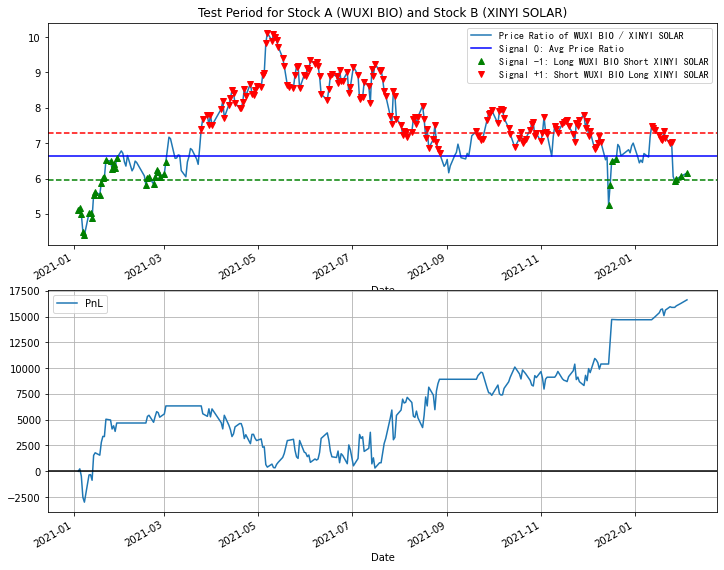

In [ ]:
print("Entry Point (Divergence) Signal == -1 (Long A Short B): Long", PAIR_STOCK_A, "and Short", PAIR_STOCK_B, "when the BUY/SELL price ratio <", tradingParams['longA_shortB_ratio'])
print("Entry Point (Divergence) Signal == 1 (Short A Long B): Short", PAIR_STOCK_A, "and Long", PAIR_STOCK_B, "when the BUY/SELL price ratio >", tradingParams['shortA_longB_ratio'])
print("Exit Poiont (Convergence) Signal == 0 : Within the above range or Unwind the open Long/Short positions at average price ratio: ", tradingParams['avgPxRatio'])
print("------------------------------------------------------------------------------------------------------------")
# Backtest a Pair in test period
backTest_df = backTest(testData, tradingParams, PAIR_STOCK_A, PAIR_STOCK_B)

# Calcuate the PnL in test period
print("Use the default $20,000 when entering the trade (i.e. create $20,000 long and $20,000 short exposure at the same time)")
print("Assume no transaction cost, perfect execution (can long/short at equal dollar amount), no short borrowing cost)")
pnl, pnl_df = pairslib.calcPnl(backTest_df)
print("*** PnL:", pnl)
print("==================================")
#cols = [PAIR_STOCK_A, PAIR_STOCK_B, 'pxRatio', 'signal', 'longValue', 'shortValue', 'longPos', 'shortPos', 'longPnl', 'shortPnl', 'pnl', 'totalPnl']
#pnl_df[cols].round(4)


# Plot the backtest and PnL results
pnl_df = addSignalMarker(pnl_df)
fig, axes = plt.subplots(2, 1)

labelTitle = 'Test Period for Stock A ({}) and Stock B ({})'.format(PAIR_STOCK_A, PAIR_STOCK_B)
pnl_df.pxRatio.plot(ax=axes[0], title=labelTitle, label=labelPriceRatio, legend=True)
axes[0].axhline(y=avgPxRatio, label=labelAvgPrice, color='b', linestyle='-')
pnl_df.nSignal.plot(ax=axes[0], label=labelLongAShortB, color='g', linestyle='None', marker='^', legend=True)
pnl_df.pSignal.plot(ax=axes[0], label=labelShortALongB, color='r', linestyle='None', marker='v', legend=True)

axes[0].axhline(y=longA_shortB_ratio, color='g', linestyle='--')
axes[0].axhline(y=shortA_longB_ratio, color='r', linestyle='--')
axes[0].legend(loc ='upper right', prop=CNFont)

pnl_df.totalPnl.plot(ax=axes[1], label='PnL', legend=True, figsize=(CHART_SIZE_X, 10), grid=True)
axes[1].axhline(y=0, color='black', linestyle='-')

In [ ]:
# Selects the Pairs with same sectors into the portfolio
selectedPairsDf = pairsDf[(pairsDf.sameSector == True)]
print("Total pairs with same sectors for backtesting:", len(selectedPairsDf))
print('----------------------------------------------------------')

# Research the trading params and back test the selected Pairs in test period
pairsPortfolioBackTest = researchAndBackTestPortfolio(selectedPairsDf, researchData, testData, printOutput=False)

# look at one of the pairs backtest results
# Each backtested Pairs is a dataframe with these columns (Date, stockA, stockB, signal, dollarValue)
#pairsPortfolioBackTest[0]

# Calcuate the PnL of the Pairs portfolio
pnl, pnlDf = pairslib.calcPortfolio(pairsPortfolioBackTest)
pnlDf

Total pairs with same sectors for backtesting: 8
----------------------------------------------------------
XINYI GLASS vs FLAT GLASS ---> $ 3899.2380851332546
PHARMARON vs WUXI BIO ---> $ 10148.804473043929
ZHONGSHENG HLDG vs MEIDONG AUTO ---> $ -1249.9271157199364
BANK OF CHINA vs ICBC ---> $ -390.98805361239647
HANG SENG BANK vs HSBC HOLDINGS ---> $ -958.2351989775161
GREATWALL MOTOR vs BYD COMPANY ---> $ 3710.6799392927624
LI NING vs ANTA SPORTS ---> $ -9713.100311625345
EVERSUNSHINE LS vs CG SERVICES ---> $ 5317.993063745655
PortfolioPnl: $ 10764.464881280406


stockA        stocksB           Pnl
0      XINYI GLASS     FLAT GLASS   3899.238085
1        PHARMARON       WUXI BIO  10148.804473
2  ZHONGSHENG HLDG   MEIDONG AUTO  -1249.927116
3    BANK OF CHINA           ICBC   -390.988054
4   HANG SENG BANK  HSBC HOLDINGS   -958.235199
5  GREATWALL MOTOR    BYD COMPANY   3710.679939
6          LI NING    ANTA SPORTS  -9713.100312
7  EVERSUNSHINE LS    CG SERVICES   5317.993064

In [ ]:
# Selects the Pairs with different sectors into the portfolio
selectedPairsDf = pairsDf[(pairsDf.sameSector == False)]
print("Total pairs with different sectors for backtesting:", len(selectedPairsDf))
print('----------------------------------------------------------')

# Research the trading params and back test the selected Pairs in test period
pairsPortfolioBackTest = researchAndBackTestPortfolio(selectedPairsDf, researchData, testData, printOutput=False)

# Calcuate the PnL of the Pairs portfolio
pnl, pnlDf = pairslib.calcPortfolio(pairsPortfolioBackTest)
pnlDf

Total pairs with different sectors for backtesting: 56
----------------------------------------------------------
XINYI SOLAR vs FLAT GLASS ---> $ -5541.6254184183235
MEITUAN-W vs MEIDONG AUTO ---> $ -4481.882448819779
MAN WAH HLDGS vs ZIJIN MINING ---> $ -3094.727751596176
ZHONGSHENG HLDG vs TENCENT ---> $ -3660.4923817273157
XINYI SOLAR vs XINYI GLASS ---> $ 5342.752603393983
MEITUAN-W vs ZHONGSHENG HLDG ---> $ 6679.818322222378
XIAOMI-W vs MAN WAH HLDGS ---> $ -4516.904641350184
YIHAI INTL vs CG SERVICES ---> $ -5213.518526747039
MEITUAN-W vs TECHTRONIC IND ---> $ 1743.7511184957984
GREATWALL MOTOR vs XINYI SOLAR ---> $ -3396.7996724570603
WUXI BIO vs XINYI SOLAR ---> $ 15746.846393450869
PHARMARON vs WUXI APPTEC ---> $ 2796.930455188958
ZIJIN MINING vs MENGNIU DAIRY ---> $ -2312.7739749742505
MENGNIU DAIRY vs MAN WAH HLDGS ---> $ 5714.511651927405
WUXI BIO vs MAN WAH HLDGS ---> $ 5684.872612819734
XIAOMI-W vs XINYI GLASS ---> $ -7054.3370358346765
TENCENT vs MEITUAN-W ---> $ 1276.8

stockA          stocksB           Pnl
0       XINYI SOLAR       FLAT GLASS  -5541.625418
1         MEITUAN-W     MEIDONG AUTO  -4481.882449
2     MAN WAH HLDGS     ZIJIN MINING  -3094.727752
3   ZHONGSHENG HLDG          TENCENT  -3660.492382
4       XINYI SOLAR      XINYI GLASS   5342.752603
5         MEITUAN-W  ZHONGSHENG HLDG   6679.818322
6          XIAOMI-W    MAN WAH HLDGS  -4516.904641
7        YIHAI INTL      CG SERVICES  -5213.518527
8         MEITUAN-W   TECHTRONIC IND   1743.751118
9   GREATWALL MOTOR      XINYI SOLAR  -3396.799672
10         WUXI BIO      XINYI SOLAR  15746.846393
11        PHARMARON      WUXI APPTEC   2796.930455
12     ZIJIN MINING    MENGNIU DAIRY  -2312.773975
13    MENGNIU DAIRY    MAN WAH HLDGS   5714.511652
14         WUXI BIO    MAN WAH HLDGS   5684.872613
15         XIAOMI-W      XINYI GLASS  -7054.337036
16          TENCENT        MEITUAN-W   1276.851796
17          LI NING      XINYI GLASS    -14.441293
18         XIAOMI-W         WUXI BIO  -3724.693453
19          LI NING         WUXI BIO  -7927.501659
20    KINGDEE INT'L     CHINA YOUZAN -11072.732819
21    KINGDEE INT'L      WUXI APPTEC   2428.016414
22        MEITUAN-W        PHARMARON   5005.264620
23  GREATWALL MOTOR      XINYI GLASS   3711.014525
24         XIAOMI-W     ZIJIN MINING -10760.601937
25   BYD ELECTRONIC             HKTV   6934.938778
26      XINYI SOLAR    MAN WAH HLDGS   5917.546651
27         PICC P&C       CITIC BANK   4278.598909
28     ZIJIN MINING      XINYI GLASS   5851.042013
29   TECHTRONIC IND     MEIDONG AUTO   5589.999785
30    KINGDEE INT'L        PHARMARON   6410.953545
31    MAN WAH HLDGS      XINYI GLASS  -1051.047565
32       CITIC BANK    BANK OF CHINA   1112.838164
33      XINYI GLASS         WUXI BIO   7796.324099
34          LI NING      BYD COMPANY  12950.896541
35      XINYI SOLAR         XIAOMI-W     96.476983
36      XINYI SOLAR      BYD COMPANY  -8459.260336
37      WUXI APPTEC     CHINA YOUZAN  -6524.053901
38             HKEX    TSINGTAO BREW   1310.268733
39        PHARMARON     MEIDONG AUTO   7297.024414
40             HKEX        MEITUAN-W   9252.757162
41       GEELY AUTO     ZIJIN MINING  -5810.413789
42     EVERG HEALTH   MEILAN AIRPORT  -7774.526256
43             HKEX          TENCENT  -3650.925695
44         WUXI BIO     ZIJIN MINING   1971.401962
45         WUXI BIO      BYD COMPANY  -7902.581449
46              CSC   TIANNENG POWER   1723.738633
47        MICROPORT   TIANNENG POWER   2961.379837
48     ZIJIN MINING  CHINASOFT INT'L   2262.250543
49         HAIDILAO   BYD ELECTRONIC  -5941.955330
50      XINYI SOLAR          LI NING  -6505.186452
51    KINGDEE INT'L         WUXI BIO  -2686.140713
52  GREATWALL MOTOR     ZIJIN MINING   7995.702965
53      WUXI APPTEC          TENCENT   -631.067088
54       GEELY AUTO  CHINASOFT INT'L  -2360.660031
55     CHINA YOUZAN      HUABAO INTL  -8157.714552

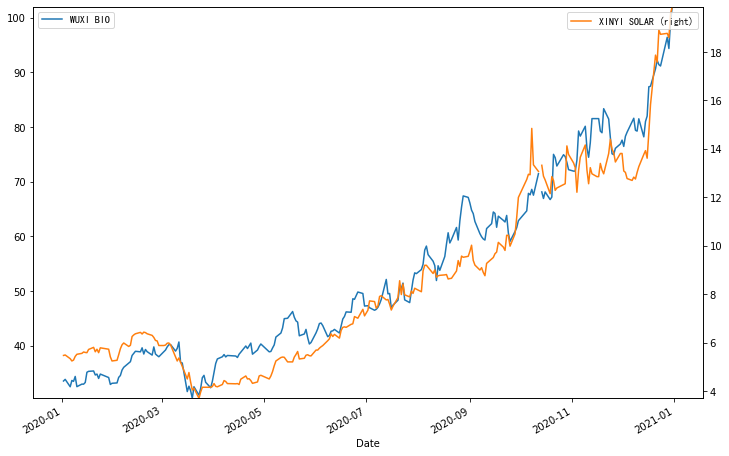

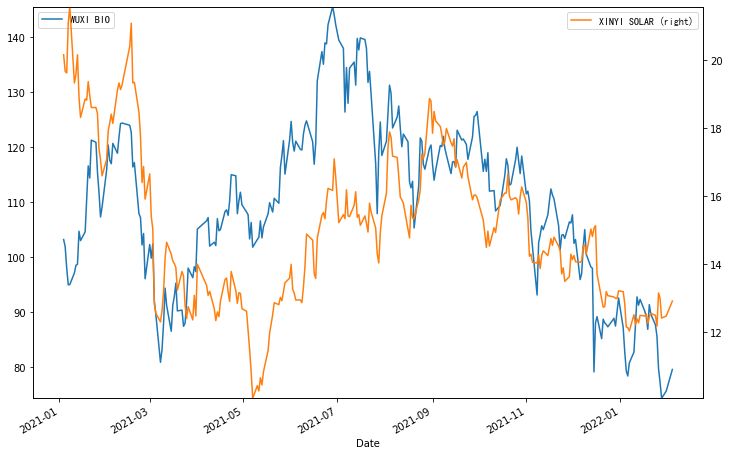

In [ ]:
# Plot the stocks pair in research and test period
stockA = 'WUXI BIO'
stockB = 'XINYI SOLAR'
plotPair(researchData, stockA, stockB, CHART_SIZE_X, CHART_SIZE_Y)
plotPair(testData, stockA, stockB, CHART_SIZE_X, CHART_SIZE_Y)